In [29]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf

import matplotlib.pyplot as plt
import plotly.express as px
import pytz  # Make sure to import pytz for timezone handling
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Normalizer

In [30]:
sp500_etf_dict = {
    'Consumer_Discretionary': 'XLY'
    ,'Consumer_Staples': 'XLP'
    ,'Energy': 'XLE'
    ,'Financial': 'XLF'
    ,'Health Care': 'XLV'
    ,'Industrial': 'XLI'
    ,'Material': 'XLB'
    ,'Technology': 'XLK'
    ,'Utilities': 'XLU'
    ,'SP_500': 'SPY'
}

In [31]:

# Periods to fetch the data for
periods = [
    'now'
    ,'5d'
    ,'30d'
    ,'90d'
    ,'180d'
    ,'1y'
    ,'3y'
    ,'5y'
    ,'10y'
    ,'15y'
    ,'20y'
    ,'25y'
    ,'30y'
           ]

# Calculate the start date for the earliest period (20 years ago), making it timezone-aware
start_date = (datetime.now(pytz.UTC) - timedelta(days=365*30)).strftime('%Y-%m-%d')

# DataFrame to store the results
df_closing_prices = pd.DataFrame(index=sp500_etf_dict.keys(), columns=periods)

# Function to get the closing price for specific periods
def get_historical_closing_prices(ticker, start_date):
    etf = yf.Ticker(ticker)
    hist = etf.history(start=start_date)
    return hist['Close']


def find_nearest_date(target_date, dates_list):
    """
    Finds and returns the date from dates_list that is closest to target_date.

    Parameters:
    - target_date: The target datetime object you're trying to find the closest match for.
    - dates_list: A list of datetime objects to search within.

    Returns:
    - closest_date: The date from dates_list that is closest to the target_date.
    """


    date_diff_dict = dict(
                        zip(
                            [abs(target_date - i).days for i in dates_list]
                            ,dates_list
                            )
                        )
    
    # Retrieve the value corresponding to the smallest key
    neaerest_date = date_diff_dict[min(date_diff_dict.keys())].strftime('%Y-%m-%d')

    return neaerest_date


# Fetch and process the data for each ETF
for sector, ticker in sp500_etf_dict.items():
    closing_prices = get_historical_closing_prices(ticker, start_date)
    for period in periods:
        if period == 'now':
            # Get the most recent closing price
            period_date = closing_prices.index[-1]
        if period.endswith('d'):
            days = int(period[:-1])
            period_date = datetime.now(pytz.UTC) - timedelta(days=days)
        elif period.endswith('y'):
            years = int(period[:-1])
            period_date = datetime.now(pytz.UTC) - timedelta(days=365*years)
        # Find the closest date index to our target period_date
        period_date_str = period_date.strftime('%Y-%m-%d')
        if period_date_str in closing_prices.index.strftime('%Y-%m-%d'):
            closest_date = period_date_str
        else:
            closest_date = find_nearest_date(period_date, closing_prices.index)
        # Store the corresponding closing price
        df_closing_prices.at[sector, period] = round(closing_prices.loc[closest_date], 4)
        df_closing_prices['ticker'] = sp500_etf_dict.values()

# Display the DataFrame
df_closing_prices


,now,5d,30d,90d,180d,1y,3y,5y,10y,15y,20y,25y,30y,ticker
Consumer_Discretionary,183.26,177.663,176.9446,179.0899,160.2935,141.0923,163.3223,106.5724,57.7834,16.2593,24.3081,21.7436,19.0753,XLY
Consumer_Staples,75.97,74.978,73.5088,70.6995,69.1035,69.9914,61.6728,48.1988,32.5409,14.3659,13.4768,15.1993,14.7464,XLP
Energy,92.05,90.826,84.1103,84.2988,87.7512,76.0704,43.0088,50.816,58.5623,28.0247,16.3811,13.4207,12.2309,XLE
Financial,41.56,40.637,39.3718,37.1999,33.3685,30.6743,31.7871,22.8905,14.9966,5.7813,15.5907,12.6415,11.5124,XLF
Health Care,145.45,144.837,144.6078,134.5342,129.1037,123.7694,110.3781,83.1133,48.927,18.7491,21.0558,19.5981,17.3651,XLV
Industrial,124.41,121.664,117.2975,112.7814,100.9242,95.1967,91.608,66.9447,42.6611,13.9132,17.6588,16.1494,14.8441,XLI
Material,91.56,90.475,84.6858,85.2936,77.5476,74.7508,73.114,48.983,38.3732,16.2817,16.5404,12.6593,11.8857,XLB
Technology,209.69,205.291,200.1794,191.7334,163.7776,142.0972,128.5449,69.7413,31.7494,12.7145,15.2193,27.9767,24.1499,XLK
Utilities,63.87,62.94,60.6886,62.1069,62.1856,62.2281,56.1375,49.852,29.1889,15.0935,11.9138,11.3428,12.3632,XLU
SP_500,520.48,509.83,495.2213,472.1829,427.3542,386.5128,375.5961,257.6804,154.9656,61.4503,75.7595,83.7051,26.2041,SPY


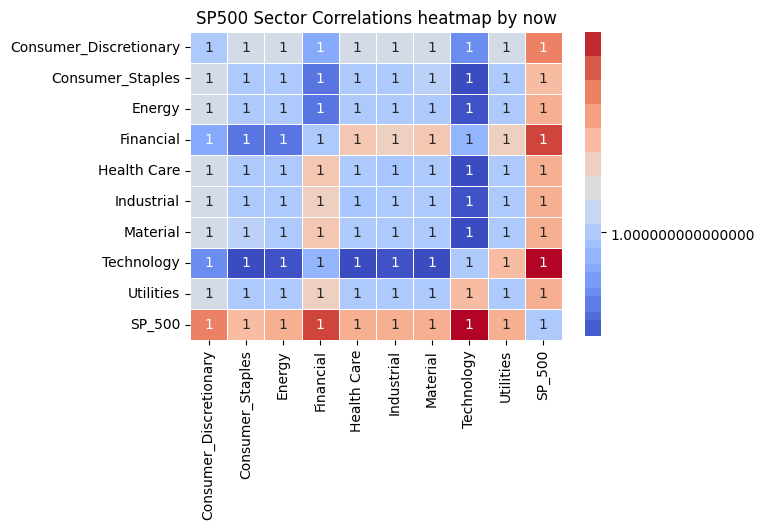

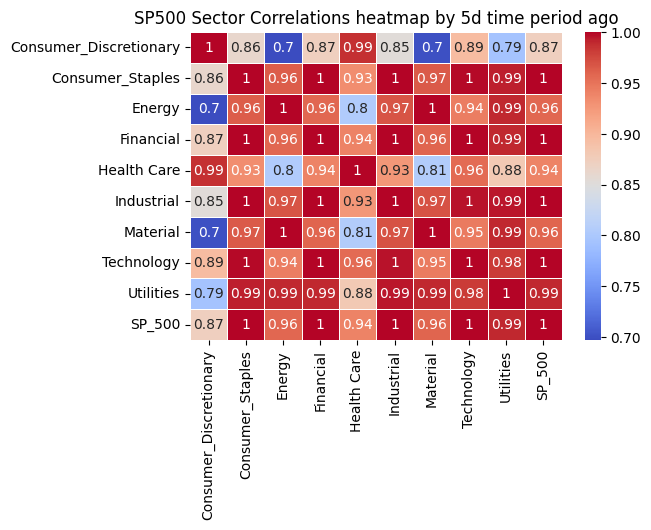

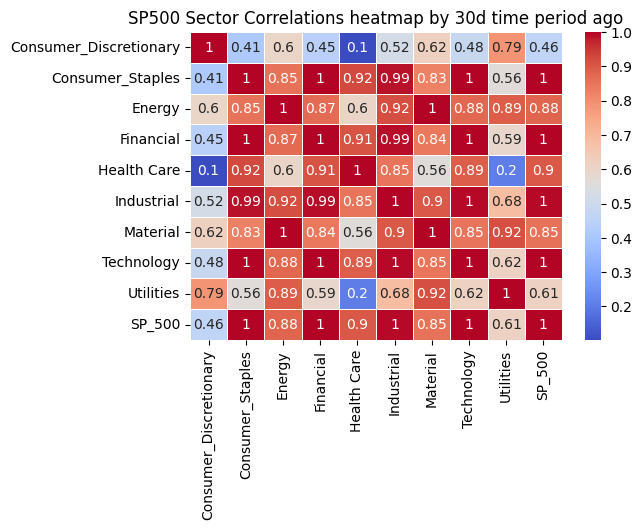

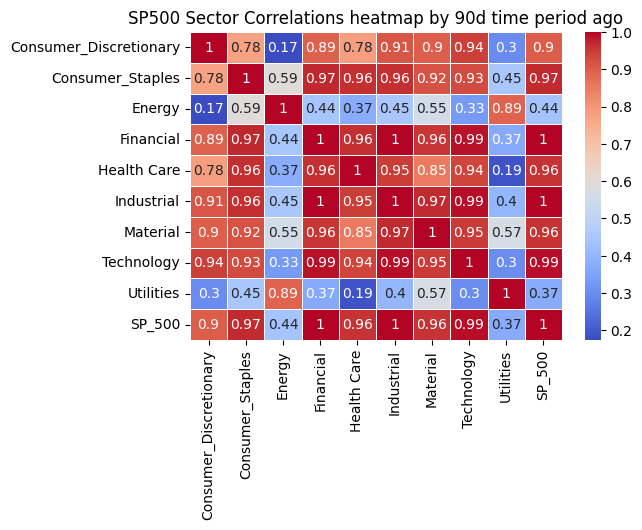

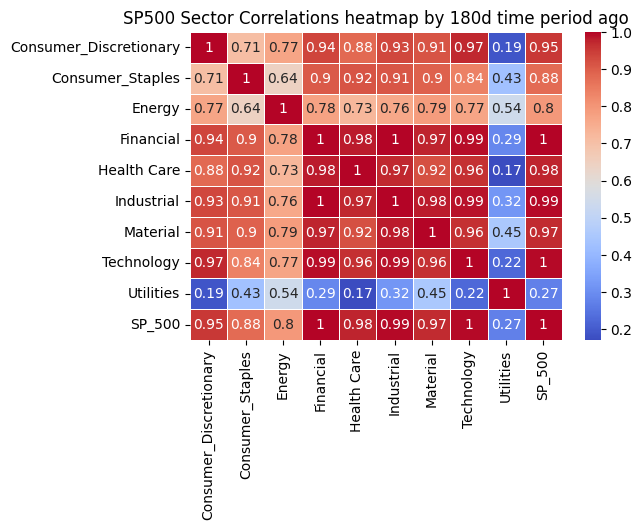

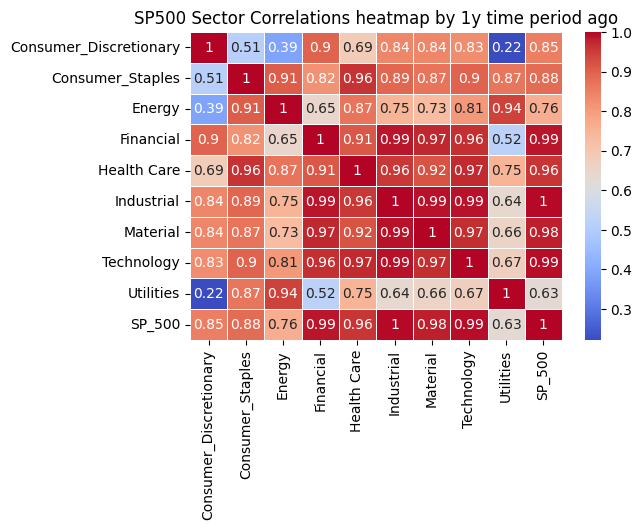

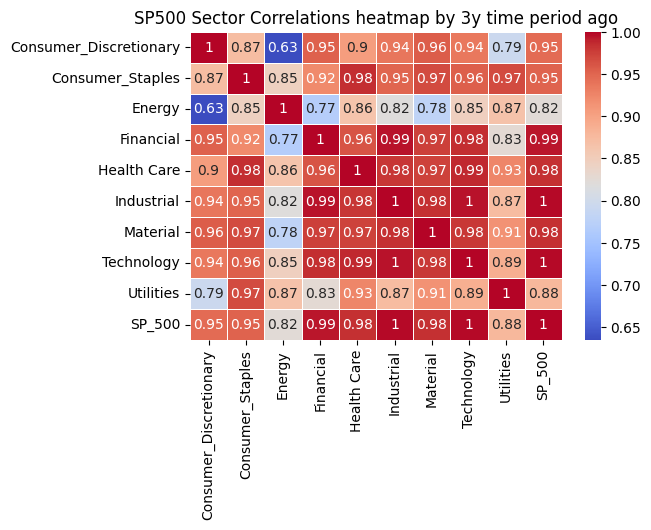

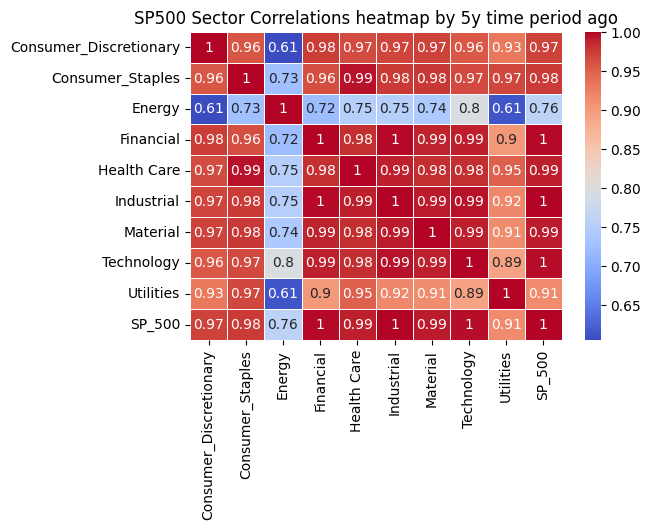

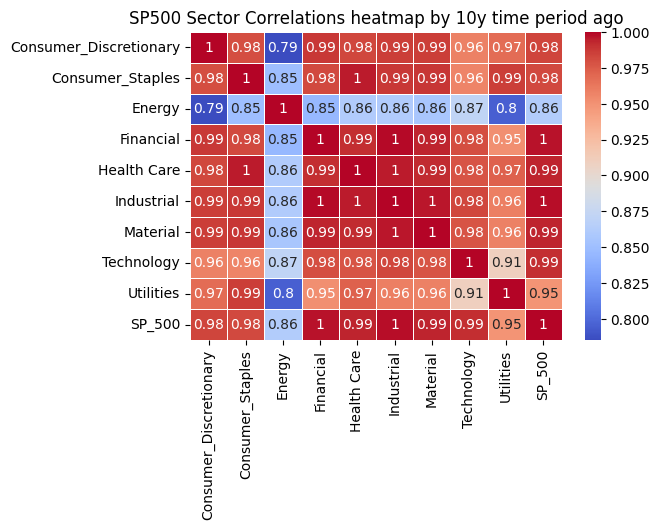

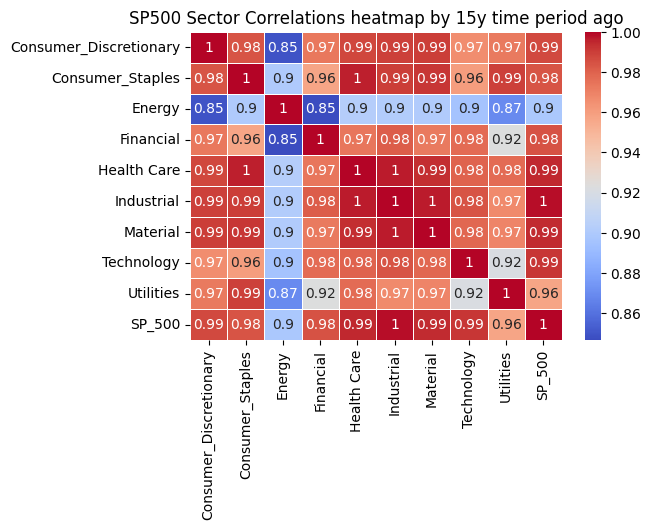

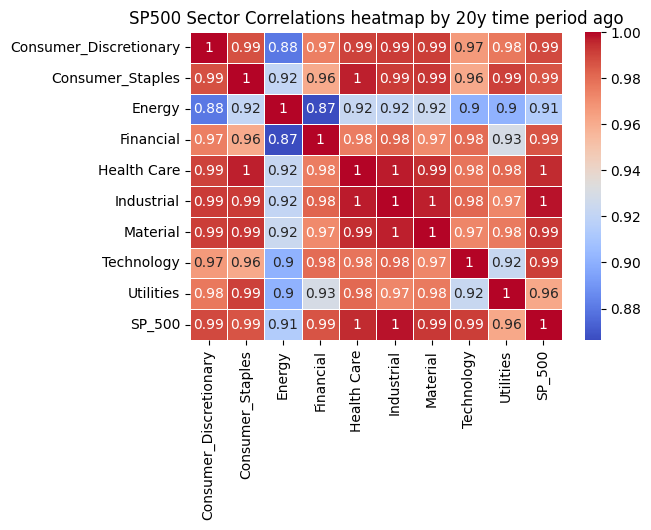

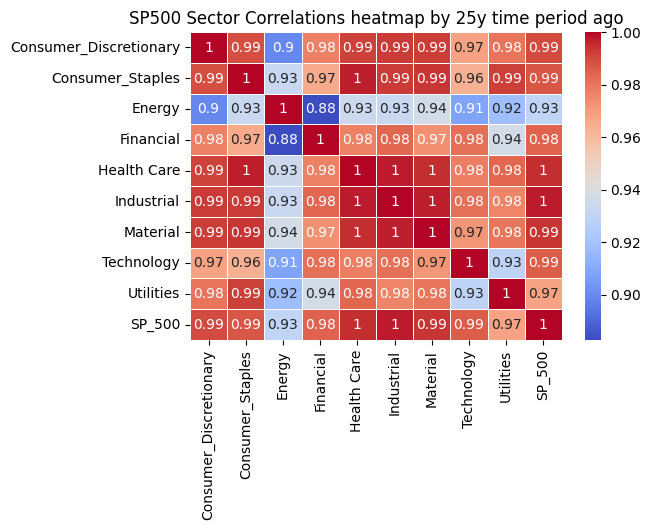

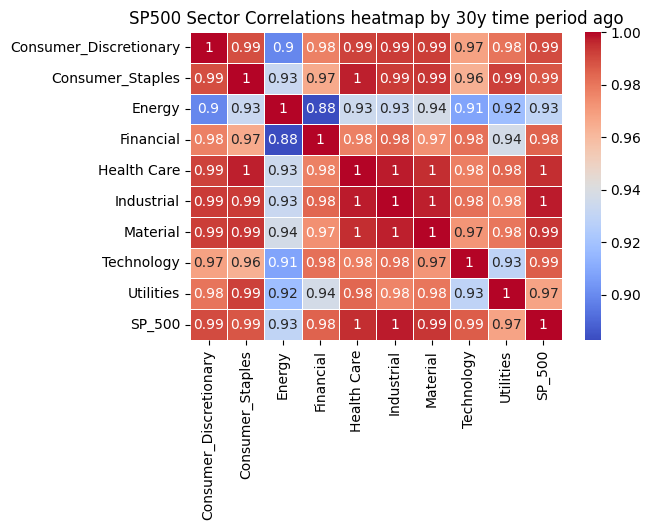

In [32]:
df_closing_prices_sub = df_closing_prices.iloc[:,0:-1].transpose()

# Initialize the StandardScaler
std_scaler = StandardScaler()
norm_scaler = Normalizer()

scaled_data = std_scaler.fit_transform(df_closing_prices_sub)
df_scaled = pd.DataFrame(scaled_data, columns=df_closing_prices_sub.columns, index=df_closing_prices_sub.index)


for index, value in enumerate(df_scaled.index): # need +1 for to include the last row of year
    corr_matrix = df_scaled.iloc[0:index+2,:].corr()

    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    if value.endswith('d'):
        plt.title(f"SP500 Sector Correlations heatmap by {value} time period ago")
    elif value.endswith('y'):
        plt.title(f"SP500 Sector Correlations heatmap by {value} time period ago")
    else:
        plt.title(f"SP500 Sector Correlations heatmap by {value}")
    plt.show()

In [35]:
import yfinance as yf
import pandas as pd

# Define the S&P 500 sector ETFs
sector_etfs = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLB', 'XLU']

# Fetch historical data for these ETFs
data = yf.download(sector_etfs, start='2020-01-01', end='2023-01-01')['Adj Close']

# Calculate the correlation matrix
correlation_matrix = data.corr()

data


[*********************100%%**********************]  9 of 9 completed


Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2020-01-02,55.635201,49.796810,28.506966,77.295654,89.714981,55.870945,55.675900,95.468811,122.339493
2020-01-03,54.736980,49.648849,28.204285,77.146660,88.706306,55.781517,55.789322,94.636856,121.298393
2020-01-06,54.498665,50.035183,28.185940,77.174583,88.917648,55.897762,55.841679,95.225784,121.635796
2020-01-07,54.434505,49.903667,28.002501,77.016304,88.879227,55.468533,55.763153,95.038826,121.442978
2020-01-08,54.626991,49.081661,28.185940,77.277016,89.830269,55.674210,55.736977,95.655777,121.809296
...,...,...,...,...,...,...,...,...,...
2022-12-23,76.612686,83.303070,33.191849,96.374954,123.325043,72.702698,68.059471,133.382904,128.040115
2022-12-27,76.680992,84.192932,33.182072,96.668823,122.157127,73.050842,68.481773,133.039902,125.962677
2022-12-28,75.510139,82.307945,33.064754,95.405243,120.187492,72.141800,67.829117,132.177444,124.904167
